###Loading the dataset

In [ ]:
from torchvision.datasets import CIFAR100
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

# Defining data preprocessing transformations
'''
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
'''
transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Setting the batch size
batch_size = 1024
number_of_labels = 100  # CIFAR-100 has 100 categories

# Load the CIFAR-100 training set
train_set = CIFAR100(root="./data", train=True, transform=transformations, download=True)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)

print("The number of images in a training set is: ", len(train_loader) * batch_size)

# Load the CIFAR-100 test set
test_set = CIFAR100(root="./data", train=False, transform=transformations, download=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

print("The number of images in a test set is: ", len(test_loader) * batch_size)
print("The number of batches per epoch is: ", len(train_loader))

# CIFAR-100 categories
classes = (
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
)

100%|██████████| 169M/169M [00:05<00:00, 31.0MB/s]


The number of images in a training set is:  50176
The number of images in a test set is:  10240
The number of batches per epoch is:  49


###Define a CNN

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

# define a CNN
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        # The first convolutional layer：3 -> 32
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # The second convolutional layer：32 -> 64
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # The first Pooling Layer
        self.pool = nn.MaxPool2d(2, 2)  # 32x32 -> 16x16

        # The third convolutional layer：64 -> 128
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # The fourth convolutional layer：128 -> 256
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # The second Pooling Layer
        self.pool2 = nn.MaxPool2d(2, 2)  # 16x16 -> 8x8

        # The fiveth convolutional layer：256 -> 512
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        # The third Pooling Layer
        self.pool3 = nn.MaxPool2d(2, 2)  # 8x8 -> 4x4

        # Fully connected layer
        self.fc1 = nn.Linear(512 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 100)  # CIFAR-100

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)  # Pooling 16x16

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)  # Pooling 8x8

        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool3(x)  # Pooling 4x4

        x = x.view(-1, 512 * 4 * 4)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # output 100 classes

        return x

# create model
model = Network()

###Define the loss function

In [ ]:
from torch.optim import Adam

# define the loss function
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.NLLLoss()
# define an optimizer with Adam optimizer
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

###Define functions for model training, as well as functions for calculating training accuracy, test accuracy, saving models, and drawing graphs

In [ ]:
from torch.autograd import Variable
import torch

# Function to save the model
def saveModel():
    path = "./myFirstModel.pth"
    torch.save(model.state_dict(), path)

# function to calculate training accuracy
def testAccuracy():
    model.eval()
    accuracy = 0.0
    total = 0.0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels.to(device)).sum().item()

    accuracy = (100 * accuracy / total)
    return accuracy

# function to calculate training accuracy
def trainAccuracy():
    model.eval()
    accuracy = 0.0
    total = 0.0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for data in train_loader:
            images, labels = data
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels.to(device)).sum().item()

    accuracy = (100 * accuracy / total)
    return accuracy

# define train function
# we have three paramaters
# num_epochs is about how much times do we need to train
# patience is using for the early stopping mechanism
# loss_threshold is also using for the early stopping mechanism
def train(num_epochs, patience=5, loss_threshold=0.01):
    # to record the best test accuracy
    best_accuracy = 0.0
    # to calculate how much continue epochs we don't have any improvement
    no_improve_epochs = 0

    # choose a device to train model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Running device is", device, "device")
    model.to(device)

    # record every epoch train accuracy
    train_accuracies = []
    # record every epoch test accuracy
    test_accuracies = []
    # record every epoch loss value
    losses = []
    # record how much epoch we run
    run_epoch_num = 0

    for epoch in range(num_epochs):
        running_loss = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # calculate the avg loss value for every epoch
        avg_loss = running_loss / len(train_loader)
        losses.append(avg_loss)

        print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

        # calculate the train accuracy and test accuracy
        train_acc = trainAccuracy()
        test_acc = testAccuracy()
        print(f'For epoch {epoch+1}, Training Accuracy: {train_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        run_epoch_num += 1

        # Early Stopping Mechanism: if we don't have any improvement in test accuracy. we will add one value in the variable of no_improve_epochs
        if test_acc > best_accuracy:
            saveModel()
            best_accuracy = test_acc
            # renew to calculate
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1

        # the first stopping condition: if our variable value of no_improve_epochs equals or greater than the value we setting. we will break our trainning process
        if no_improve_epochs >= patience:
            print(f'Early stopping at epoch {epoch+1} due to no improvement in {patience} epochs.')
            break

        # the second stopping condition: if our loss value is less than the value we setting. we also will break the trainning process
        if avg_loss < loss_threshold:
            print(f'Training stopped at epoch {epoch+1} because loss {avg_loss:.4f} is below threshold {loss_threshold}.')
            break

    return train_accuracies, test_accuracies, losses, run_epoch_num

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def make_photos(epoch_num, train_accuracies, test_accuracies, losses):
  # data
  epochs = list(range(1, epoch_num + 1))  # generate a list of integers from 1 to epoch_num

  # creating the Figure and Axes
  fig, ax1 = plt.subplots()

  # draw the accuracy curve (left axis)
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Accuracy', color='tab:blue')
  ax1.plot(epochs, train_accuracies, 'o-', label='Train Accuracy', color='tab:blue')
  ax1.plot(epochs, test_accuracies, 's-', label='Test Accuracy', color='tab:cyan')
  ax1.tick_params(axis='y', labelcolor='tab:blue')
  ax1.set_xticks(epochs)  # only show integer epochs

  step = max(1, epoch_num // 10)  # take a point every 10%
  plt.xticks(epochs[::step])  # rotate 45 degrees to prevent overlap

  ax1.legend(loc='upper left')

  # create a second y-axis and plot the loss curve
  ax2 = ax1.twinx()
  ax2.set_ylabel('Loss', color='tab:red')
  ax2.plot(epochs, losses, 'd-', label='Loss', color='tab:red')
  ax2.tick_params(axis='y', labelcolor='tab:red')
  ax2.legend(loc='upper right')

  # set the title
  plt.title('Training and Testing Accuracy & Loss Over Epochs')

  # display the chart
  plt.show()

###Test a batch of data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# function to show the images
def imageshow(img):
    img = img / 2 + 0.5
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()


# function to test the model with a batch of images and show the labels predictions
def testBatch():
    # get batch of images from the test DataLoader
    test_loader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=0)
    images, labels = next(iter(test_loader))

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images))

    # show the real labels on the screen
    print('Real labels: ', ' '.join('%5s' % classes[labels[j]]
                               for j in range(100)))

    # let's see what if the model identifiers the  labels of those example
    outputs = model(images)

    # we got the probability for every 100 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)

    # let's show the predicted labels on the screen to compare with the real ones
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(100)))

    # visualizing predictions vs actual labels
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(10, 10, i + 1)  # arranging in 10x10 grid for 100 images
        plt.imshow(np.transpose((images[i] / 2 + 0.5).numpy(), (1, 2, 0)))  # show each image
        plt.title(f"Real: {classes[labels[i]]}\nPred: {classes[predicted[i]]}", fontsize=6)
        plt.axis('off')

    # automatically adjust subplots to make space for titles
    plt.subplots_adjust(hspace=1, wspace=1)

    plt.show()

###Main program entry file

Running device is cuda:0 device
Epoch 1, Loss: 4.2294
For epoch 1, Training Accuracy: 8.86%, Test Accuracy: 8.94%
Epoch 2, Loss: 3.9576
For epoch 2, Training Accuracy: 12.98%, Test Accuracy: 13.04%
Epoch 3, Loss: 3.5640
For epoch 3, Training Accuracy: 17.10%, Test Accuracy: 17.09%
Epoch 4, Loss: 3.3352
For epoch 4, Training Accuracy: 20.92%, Test Accuracy: 20.22%
Epoch 5, Loss: 3.1303
For epoch 5, Training Accuracy: 25.52%, Test Accuracy: 24.66%
Epoch 6, Loss: 2.9703
For epoch 6, Training Accuracy: 27.09%, Test Accuracy: 25.98%
Epoch 7, Loss: 2.8287
For epoch 7, Training Accuracy: 30.26%, Test Accuracy: 28.08%
Epoch 8, Loss: 2.7054
For epoch 8, Training Accuracy: 32.63%, Test Accuracy: 30.87%
Epoch 9, Loss: 2.5756
For epoch 9, Training Accuracy: 35.75%, Test Accuracy: 32.81%
Epoch 10, Loss: 2.4720
For epoch 10, Training Accuracy: 36.87%, Test Accuracy: 33.91%
Epoch 11, Loss: 2.3723
For epoch 11, Training Accuracy: 39.77%, Test Accuracy: 36.13%
Epoch 12, Loss: 2.2589
For epoch 12, Train

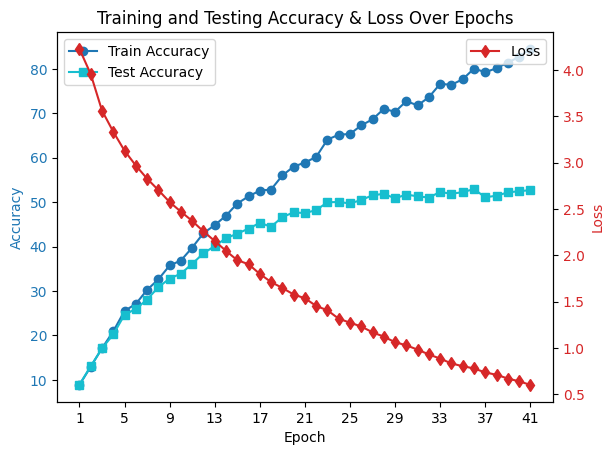

Finished Training


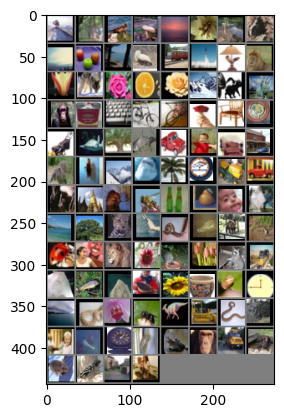

Real labels:  mountain forest  seal mushroom   sea tulip camel butterfly cloud apple   sea skunk streetcar rocket  lamp  lion tulip  wolf  rose orange  rose mountain skunk dinosaur chimpanzee   can keyboard bicycle bicycle  rose chair plate lawn_mower turtle palm_tree shark pickup_truck   boy couch house porcupine cockroach mountain shark palm_tree clock lawn_mower pickup_truck skunk castle beaver   bee bottle  pear  baby flatfish   sea oak_tree leopard rocket snail crocodile camel rabbit beetle  girl  lion sunflower porcupine tulip raccoon train   ray trout flatfish flatfish sunflower  bowl snail clock   sea snake orchid   bee dinosaur tractor snake forest   boy   ray clock caterpillar crocodile chimpanzee   bus chimpanzee mouse skunk house  girl
Predicted:  rabbit shrew lizard trout   sea squirrel shrew shrew cloud apple shrew shrew train rocket  girl beaver aquarium_fish  wolf tulip mushroom mushroom shark bottle shrew chimpanzee television  bear squirrel lobster keyboard bottle fla

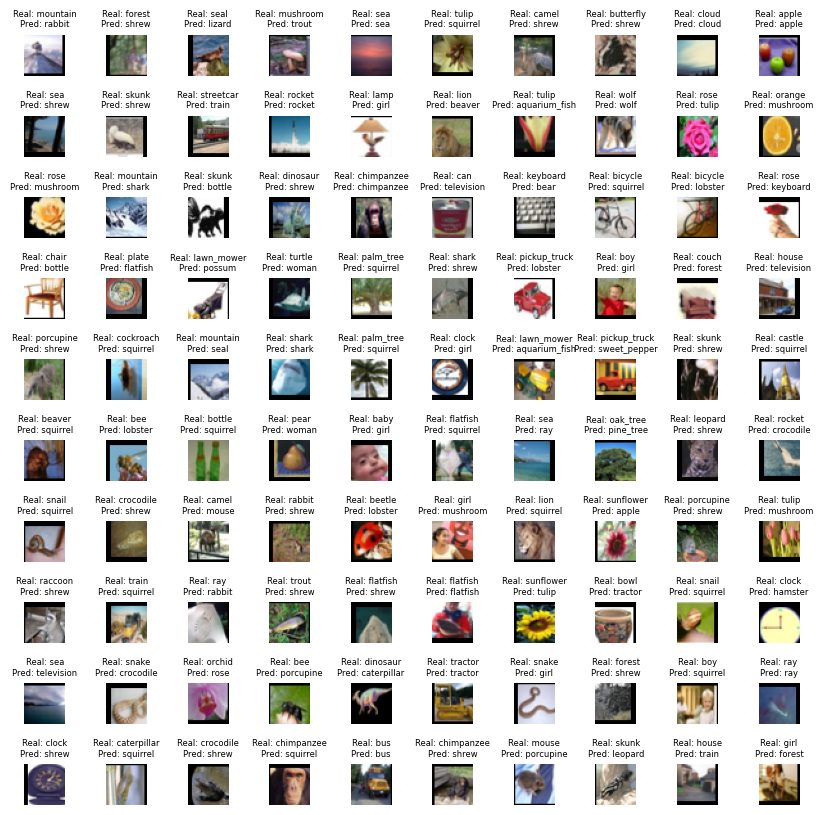

In [ ]:
if __name__ == "__main__":

    # build our model
    epoch_num = 50
    train_accuracies, test_accuracies, losses, run_epoch_num = train(epoch_num)
    make_photos(run_epoch_num, train_accuracies, test_accuracies, losses)
    print('Finished Training')

    # test which classes performed well
    testAccuracy()

    # let's load the model we just created and test the accuracy per label
    model = Network()
    path = "myFirstModel.pth"
    model.load_state_dict(torch.load(path))

    # test with batch of images
    testBatch()